# Imports

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
from derivative import dxdt

# Time Parameters

In [49]:
tiempo_vida_inicial = 20
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
pasos_integracion = tiempo_vida_maximo-  tiempo_vida_inicial         #Definicion de los pasos de integracion de algoritmo   #Tasa de propagacion de daño
h = (tiempo_vida_maximo-tiempo_vida_inicial)/pasos_integracion  

# Functions

In [55]:
def f(frailty, internal_damage_rate, exogenous_damage_rate, t=None):
    return (internal_damage_rate*frailty + exogenous_damage_rate)

def Runke_Kutta_Method(temporal_evolution:list, internal_damage_rate, exogenous_damage_rate, mortality_rate, coupling_factor, condicion_inicial):
    frailty = condicion_inicial                                        #Initial condition     
    frailty_index = np.empty((len(temporal_evolution)))
    for index, t in enumerate(temporal_evolution):
        frailty_index[index] = frailty
        k1 = h*f(frailty, internal_damage_rate, exogenous_damage_rate, t=t)
        k2 = h*f(frailty + 0.5*k1, internal_damage_rate, exogenous_damage_rate, t=t +0.5*h)
        frailty += k2

    gompertz_law = mortality_rate*(frailty_index**(coupling_factor/internal_damage_rate))
    return frailty_index, gompertz_law, temporal_evolution

# Exogenous Damage Rate Modification

In [56]:
mortality_rate = 4.3*(10**(-6))     #Tasa de mortalidad #NO MODIFICA COMPORTAMIENTO LEY DE GOMPERTZ
internal_damage_rate = 0.09
coupling_factor = 0.2            #Factor de acoplamiento entre frailty index y gompertz
condicion_inicial = 0.05

parametro_beta = []
parametro_R = []

exogenous_damage_rate_steps_modification = np.arange(0.000001, 0.005 + 0.00001, 0.00001)

for exogenous_damage_rate in exogenous_damage_rate_steps_modification: 
    temporal_evolution = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,h) 
    frailty_index_differential_equation,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method(temporal_evolution,internal_damage_rate, exogenous_damage_rate, mortality_rate, coupling_factor, condicion_inicial)
    
    valores_beta_R = np.empty((2), dtype = object)
    temporal_evolution = temporal_evolution_differential_equation
    data = gompertz_law_differential_equation
    derivative_process = dxdt(data, temporal_evolution, kind="finite_difference", k=3)
    beta_values = derivative_process/data
    R_values = data/np.e**(beta_values*temporal_evolution)

    parametro_R.append(R_values)
    parametro_beta.append(beta_values)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


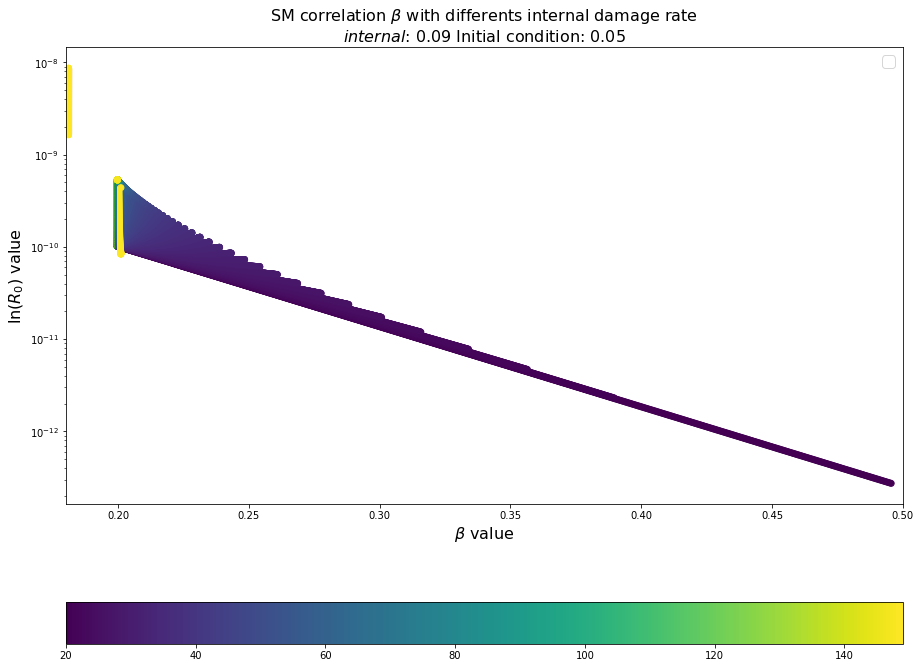

In [65]:
X = temporal_evolution
A_values_2 = np.arange(0, len(temporal_evolution), 1)  # Replace this with your parameter A values
fig, ax = plt.subplots(figsize=(15,12))
for i in range(len(parametro_beta)):

    colors2 = plt.cm.viridis(A_values_2 / max(A_values_2))  # Normalize A_values between 0 and 1
    ax.scatter(parametro_beta[i], parametro_R[i], color = colors2) 

sm2 = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(temporal_evolution), vmax=max(temporal_evolution)))
sm2.set_array([])  # Set an empty array to create the colorbar based on the colormap

cbar2 = plt.colorbar(sm2, orientation = "horizontal")
ax.set_title(r"SM correlation $\beta$ with differents internal damage rate" + "\n" + rf"$internal$: {internal_damage_rate} Initial condition: {condicion_inicial}", fontsize= 16)
ax.set_xlabel(r'$\beta$ value', fontsize=16)
ax.set_ylabel(r'$\ln(R_0)$ value', fontsize=16)
ax.set_yscale("log")
ax.set_xlim(0.18, 0.5)
#cbar2.set_label(r"$\frac{\partial{f(t)}}{\partial{t}} = \alpha f + d$" + "\n" + "Model", fontsize=20)
ax.legend(fontsize = 16)
#plt.savefig("SM_correlation_scatter_general.jpg", dpi = 1000)

501it [00:00, 1592.04it/s]


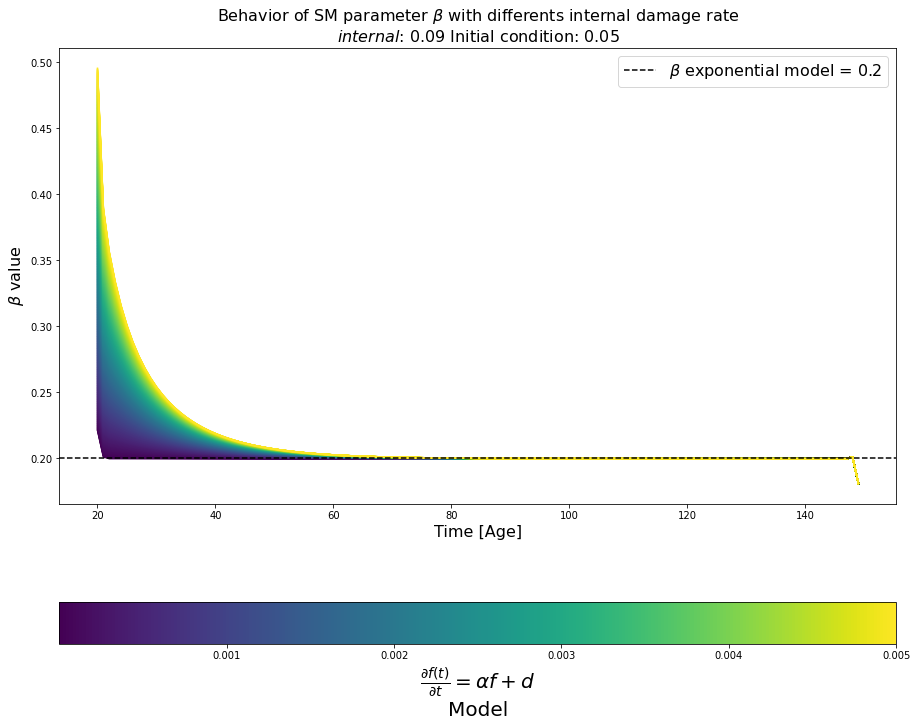

In [12]:
X = temporal_evolution
A_values_2 = np.arange(0, len(parametro_beta), 1)  # Replace this with your parameter A values
fig, ax = plt.subplots(figsize=(15,12))
for Y, A in tqdm(zip(parametro_beta, A_values_2)):
    colors2 = plt.cm.viridis(A_values_2 / max(A_values_2))  # Normalize A_values between 0 and 1
    ax.plot(X, Y, color=colors2[A]) 
sm2 = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(exogenous_damage_rate_steps_modification), vmax=max(exogenous_damage_rate_steps_modification)))
sm2.set_array([])  # Set an empty array to create the colorbar based on the colormap
ax.axhline(y=coupling_factor, color='black', linestyle='--', label=rf'$\beta$ exponential model = {coupling_factor}')
cbar2 = plt.colorbar(sm2, orientation = "horizontal")
ax.set_title(r"Behavior of SM parameter $\beta$ with differents internal damage rate" + "\n" + rf"$internal$: {internal_damage_rate} Initial condition: {condicion_inicial}", fontsize= 16)
ax.set_xlabel(r'Time [Age]', fontsize=16)
ax.set_ylabel(r'$\beta$ value', fontsize=16)
cbar2.set_label(r"$\frac{\partial{f(t)}}{\partial{t}} = \alpha f + d$" + "\n" + "Model", fontsize=20)
ax.legend(fontsize = 16)
#plt.savefig("Modificacion_internal_damage_rate.jpg", dpi = 500)

# Internal Damage Rate Modification